In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('data/2014_-_9_Anonymous_Clipper.csv')

In [ ]:
#Strip the column names of white space
for col in ['AgencyName', 'PaymentProductName', 'RouteName']:
    df[col] = df[col].str.strip()

In [ ]:
#Convert time to floats
df['TagOnTime_Time'] = pd.to_timedelta(df['TagOnTime_Time'])/pd.offsets.Hour(1)
df['TagOffTime_Time'] = pd.to_timedelta(df['TagOffTime_Time'])/pd.offsets.Hour(1)

In [ ]:
#Drop unneeded columns
df.drop(columns=['Year',
                 'Month',
                 'CircadianDayOfWeek_Name',
                 'AgencyName',
                 'PaymentProductName',
                 'TagOnLocationName',
                 'RouteName',
                 'TagOffLocationName'], inplace=True)

In [ ]:
df.info()

In [ ]:
#Create aggregation function dictionary
agg_funcs = {}
for col in df.columns:
    if col == 'TagOnTime_Time':
        agg_funcs[col] = 'min'
    elif col in ('TripSequenceID', 'TagOffTime_Time'):
        agg_funcs[col] = 'max'
    elif col not in ('CircadianDayOfWeek', 'RandomWeekID', 'ClipperCardID'):
        agg_funcs[col] = 'sum'

In [ ]:
df = df.groupby(['CircadianDayOfWeek', 'RandomWeekID', 'ClipperCardID']).agg(agg_funcs).reset_index()

In [ ]:
#Fill NaNs
df['TagOffLocationID'] = df['TagOffLocationID'].fillna(0)
df['TagOffTime_Time'] = df['TagOffTime_Time'].fillna(0)
df['TagOffLocationID'] = df['TagOffLocationID'].astype('int')

In [ ]:
df.head()

In [ ]:
df.to_csv('data/train.csv', index=False)

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

In [138]:
df = pd.read_csv('data/train.csv')

In [139]:
df.head()

,CircadianDayOfWeek,RandomWeekID,ClipperCardID,TripSequenceID,AgencyID,PaymentProductID,FareAmount,TagOnTime_Time,TagOnLocationID,RouteID,TagOffTime_Time,TagOffLocationID
0,1,6,00003C685DF3C97ECB76596252C378E749BE93C8,5,90,2515,0.00,5.833333,0,688,0.0,0
1,1,6,0002C67294C466CB63DAD7EFCA043CA71EF69EB9,1,18,531,0.00,17.833333,11,0,0.0,0
2,1,6,0004D97D359676F2DD49726ABDDD5A0393BE4096,1,18,0,2.25,17.000000,0,138,0.0,0
3,1,6,00058666BC31BEBB900FC23C42DDC81E86A6A30B,1,18,514,0.00,12.666667,0,138,0.0,0
4,1,6,00061A5B9BD884C03449852E83C5E29DB4C34631,1,4,0,5.95,15.333333,39,0,16.5,8


In [140]:
#Normalize data
for col in df.columns:
    if col not in ('CircadianDayOfWeek', 'RandomWeekID', 'ClipperCardID'):
        df[col] = df[col]/df[col].max()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x17b4eda90>]],
      dtype=object)

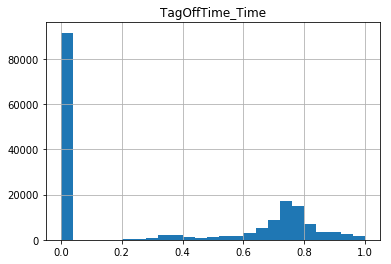

In [141]:
df[(df['CircadianDayOfWeek']==4) & (df['RandomWeekID']==8)][['TagOffTime_Time']].hist(bins=25)

In [142]:
df_baseline = df[(df['CircadianDayOfWeek']==4) & (df['RandomWeekID']==8)]

In [143]:
df = df[~((df['CircadianDayOfWeek']==4) & (df['RandomWeekID']==8))]

In [144]:
#Drop uneeded columns
df_baseline.drop(columns=['CircadianDayOfWeek', 'RandomWeekID'], inplace=True)

In [145]:
#Reset indexes
df_baseline.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [147]:
#Pop Clipper ID
df_baseline_IDs = df_baseline.pop('ClipperCardID')

In [150]:
df_baseline_IDs = df_baseline_IDs.reset_index()

In [153]:
df_baseline_IDs.rename(index=str, columns={'index': 'UserID'}, inplace=True)

In [80]:
feature_cols = ['TripSequenceID', 'AgencyID', 'PaymentProductID', 'FareAmount',
        'TagOnTime_Time', 'TagOnLocationID', 'RouteID', 'TagOffTime_Time',
        'TagOffLocationID']

In [195]:
def assign_users(group):
    print ("Starting CircadianDayOfWeek {}, RandomWeekID {}".format(int(group['CircadianDayOfWeek'].unique()),
                                                                    int(group['RandomWeekID'].unique())))
    #In the baseline array, the index is the UserID
    X = df_baseline.copy()
    user_ids = []
    for i, row in group.iterrows():
        #Calculate distances in feature space
        d = euclidean_distances(X, [row[feature_cols]])
        
        #Get row number of closest item
        row_number = np.argmin(d)
        
        #Get user ID from row
        user_id = X.iloc[row_number].name
        
        #print("Row {}: ClipperCardID {} matched to UserID {}".format(i, row['ClipperCardID'], user_id))
        
        #Add UserID to return array
        user_ids.append(user_id)
        
        #Drop row with this UserID so we can't assign it again
        X.drop(user_id, inplace=True)
        
    return pd.DataFrame({'UserID': np.array(user_ids), 'ClipperCardID': group['ClipperCardID']})

In [196]:
df_results = df.groupby(['CircadianDayOfWeek', 'RandomWeekID']).apply(assign_users)

Starting CircadianDayOfWeek 1, RandomWeekID 6
Starting CircadianDayOfWeek 1, RandomWeekID 6
Starting CircadianDayOfWeek 1, RandomWeekID 7
Starting CircadianDayOfWeek 1, RandomWeekID 8
Starting CircadianDayOfWeek 2, RandomWeekID 6
Starting CircadianDayOfWeek 2, RandomWeekID 7
Starting CircadianDayOfWeek 2, RandomWeekID 8
Starting CircadianDayOfWeek 3, RandomWeekID 6
Starting CircadianDayOfWeek 3, RandomWeekID 7
Starting CircadianDayOfWeek 3, RandomWeekID 8
Starting CircadianDayOfWeek 4, RandomWeekID 6
Starting CircadianDayOfWeek 4, RandomWeekID 7
Starting CircadianDayOfWeek 5, RandomWeekID 6
Starting CircadianDayOfWeek 5, RandomWeekID 7
Starting CircadianDayOfWeek 5, RandomWeekID 8
Starting CircadianDayOfWeek 6, RandomWeekID 6
Starting CircadianDayOfWeek 6, RandomWeekID 7
Starting CircadianDayOfWeek 6, RandomWeekID 8
Starting CircadianDayOfWeek 7, RandomWeekID 6
Starting CircadianDayOfWeek 7, RandomWeekID 7
Starting CircadianDayOfWeek 7, RandomWeekID 8


In [203]:
#Recombine to for Clipper/user ID lookup
df_clipper_users = pd.concat([df_baseline_IDs, df_results])

In [205]:
df_clipper_users = df_clipper_users[['ClipperCardID', 'UserID']]

In [210]:
df_clipper_users.sort_values('ClipperCardID', inplace=True)

In [211]:
df_clipper_users.to_csv('data/clipper_users.csv', index=False)

In [224]:
df_clipper_users.groupby('UserID').count().hist(bins=19)

ClipperCardID    17.20625
dtype: float64